In [1]:
!git clone https://github.com/ahmed-fz11/LLM-Nav.git

fatal: destination path 'LLM-Nav' already exists and is not an empty directory.


In [2]:
%cd LLM-Nav

/kaggle/working/LLM-Nav


In [3]:
!git pull
!pip install openai transformers torch sentence-transformers pandas pillow glob2

Already up to date.


In [4]:
!pip install -U bitsandbytes
!pip install --upgrade transformers
!pip install openai

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The goal is:  I want to navigate to the area between the kitchen island and the gray rug.


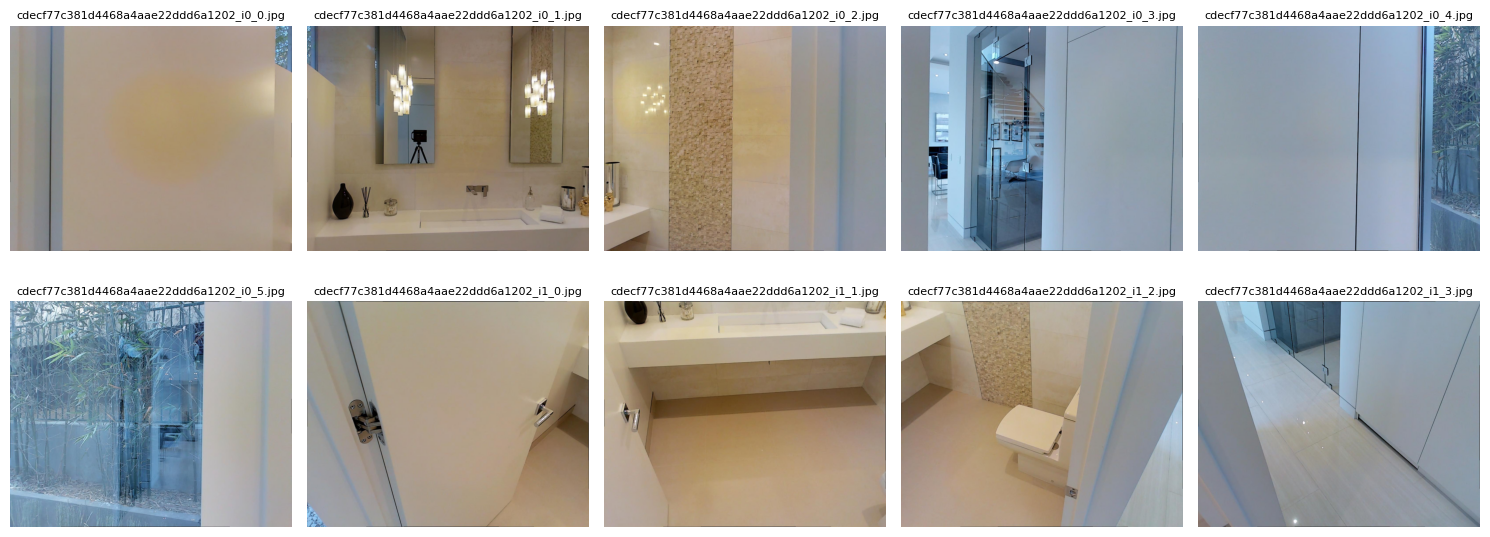

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Current generated hlp:  To reach the area between the kitchen island and the gray rug, navigate towards the left side of the image, as it appears to be the most direct route.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Checking similiarity with last appended plan
Generated hlp appended:  To reach the area between the kitchen island and the gray rug, navigate towards the left side of the image, as it appears to be the most direct route.


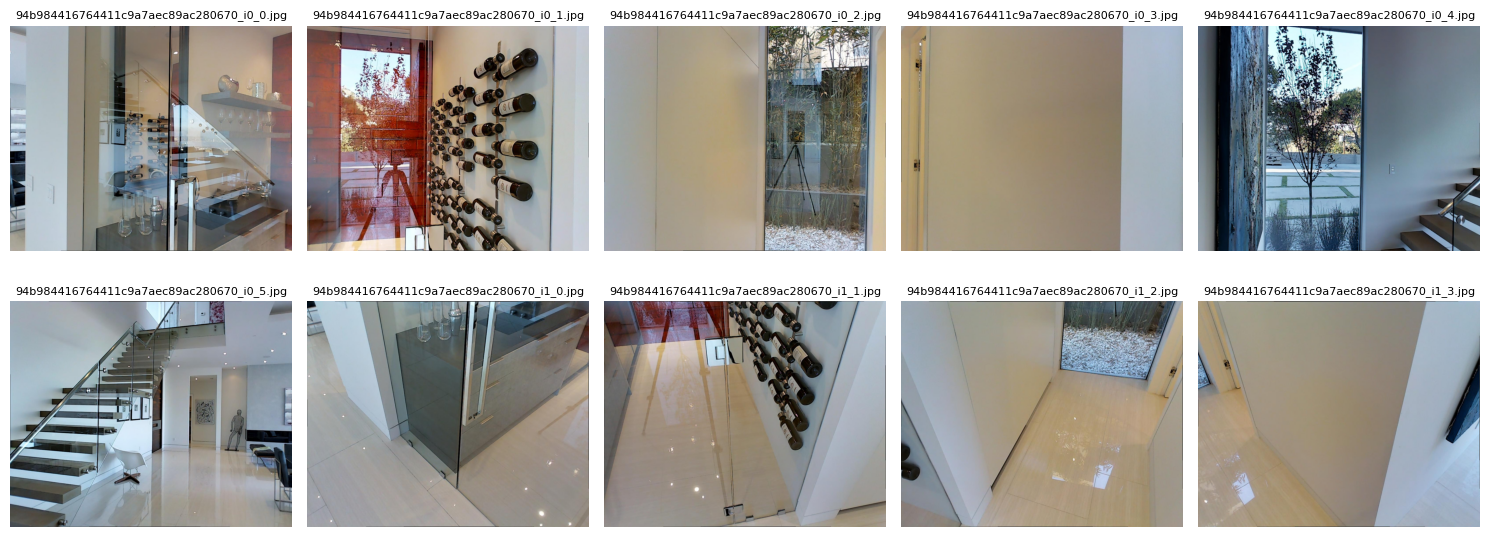

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Current generated hlp:  To reach the area between the kitchen island and the gray rug, navigate towards the kitchen island, then turn left and proceed forward.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Checking similiarity with last appended plan
Generated hlp not appended


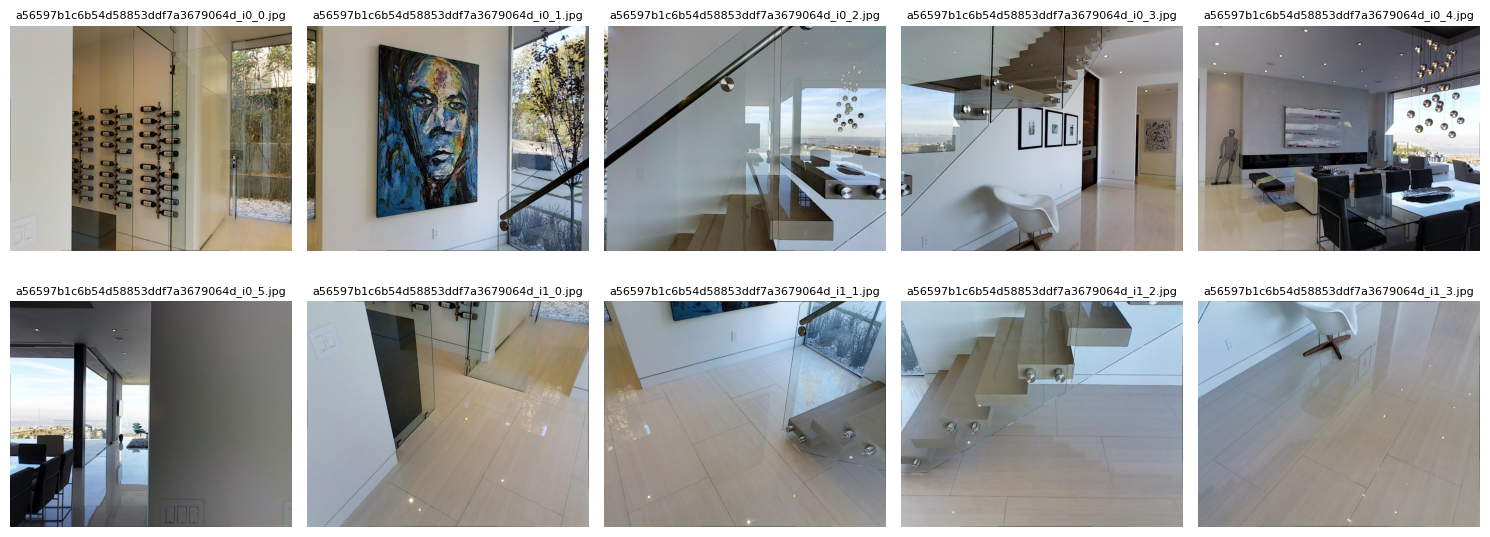

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Current generated hlp:  To reach the area between the kitchen island and the gray rug, navigate towards the kitchen island, then turn left and proceed forward.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Checking similiarity with last appended plan
Generated hlp not appended


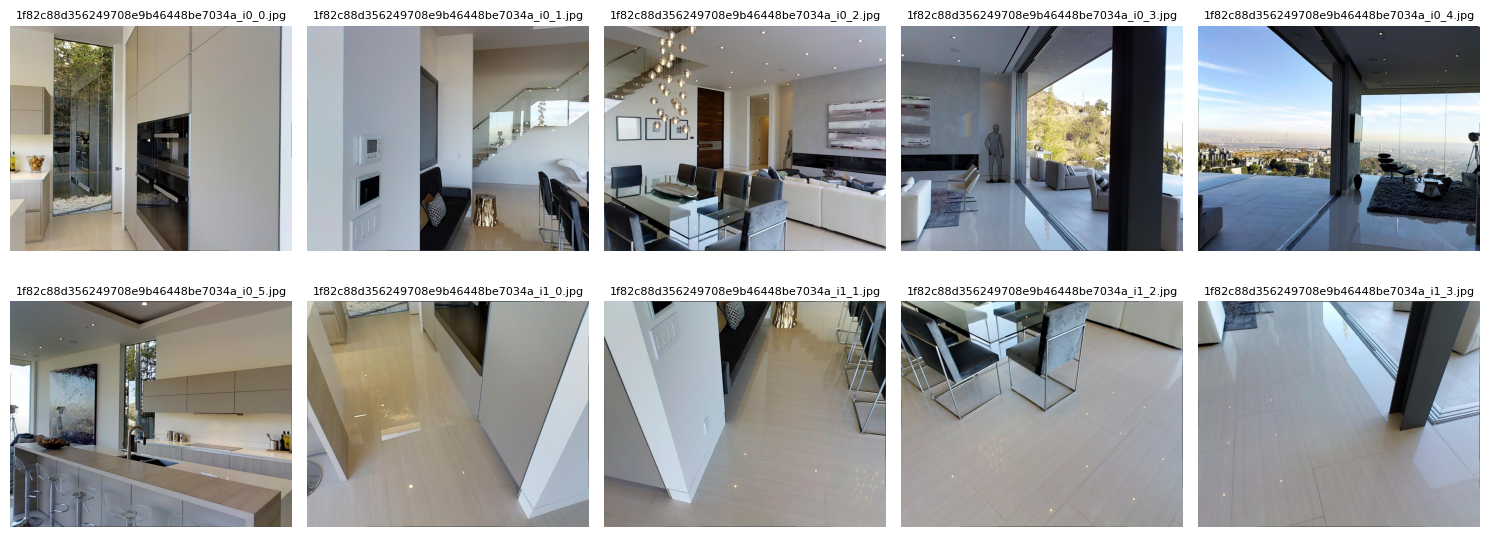

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Current generated hlp:  To reach the area between the kitchen island and the gray rug, navigate towards the kitchen island, then turn left and proceed forward.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Checking similiarity with last appended plan
Generated hlp not appended


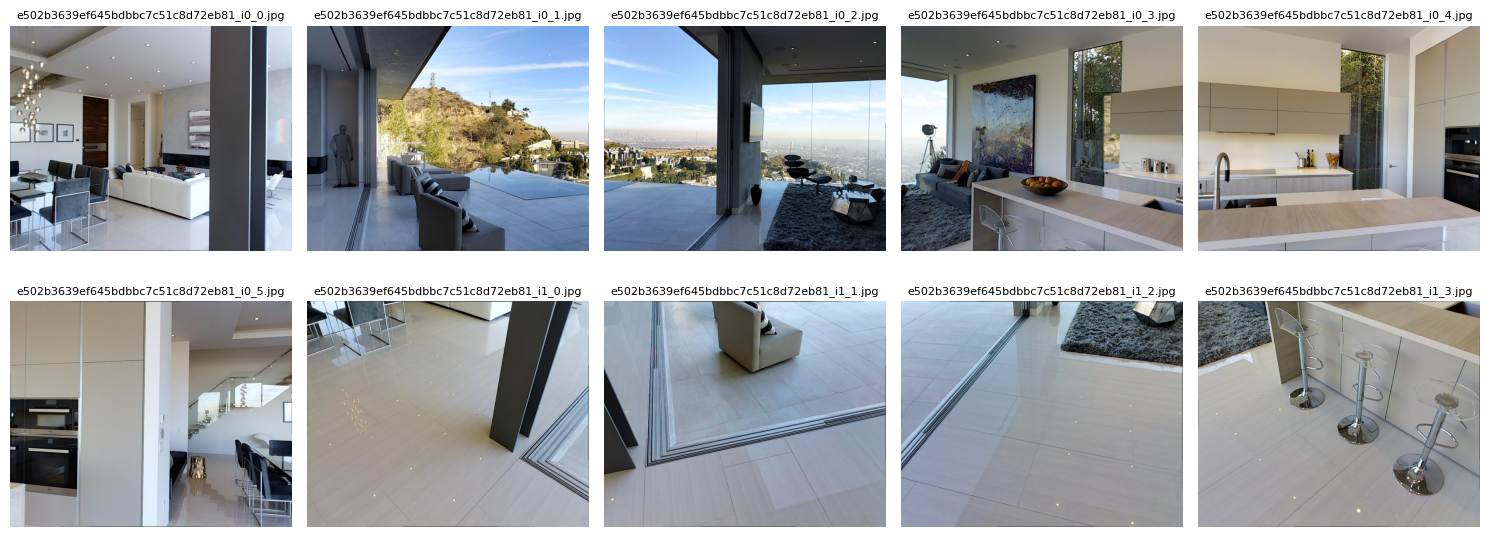

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Current generated hlp:  To reach the area between the kitchen island and the gray rug, navigate towards the kitchen island, then turn left and proceed forward.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Checking similiarity with last appended plan
Generated hlp not appended


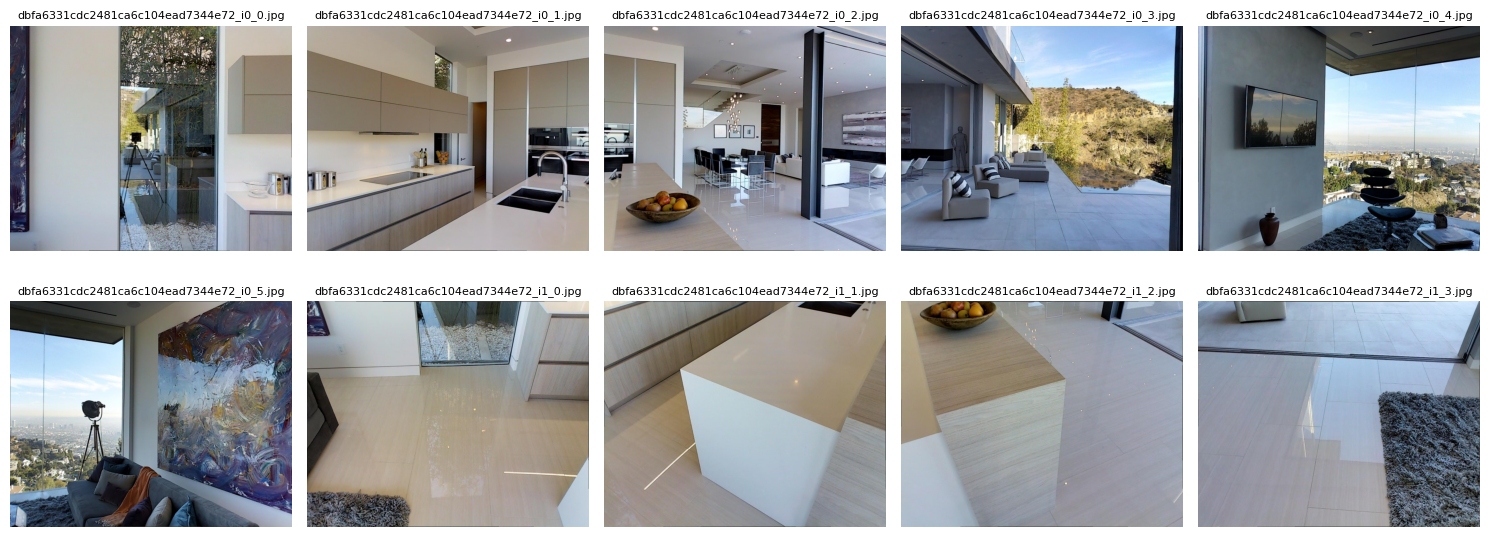

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Current generated hlp:  To reach the area between the kitchen island and the gray rug, navigate towards the kitchen island, then turn right and proceed forward.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Checking similiarity with last appended plan
Generated hlp not appended
final plan =  ['To reach the area between the kitchen island and the gray rug, navigate towards the left side of the image, as it appears to be the most direct route.']


In [5]:
from pydantic import BaseModel
from openai import OpenAI
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import math


from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer, util  # For embedding and similarity

# Initialize the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose any other suitable model

CLIENT = OpenAI(api_key="")

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True,
)

def summarize_experiences(past_summary, hlp):
    input_text = f"Past Summary: {past_summary}\nNew plan: {hlp}"
    try:
        response = CLIENT.chat.completions.create(
            model='gpt-3.5-turbo',
            messages=[
                {"role": "system", "content": 
                 """You are a summarizer which gives an answer in past tense.Given a past summary and and recent actions you must combine this into a single summary of past experiences. Give your answer in past tense, telling me what I have done till now.
                Use the format:
                Summary:"""},
                {"role": "user", "content": input_text}
            ],
            temperature=0,
            max_tokens=100,
            top_p=1,
            frequency_penalty=0.0,
            presence_penalty=0.0,
        )
        output_text = response.choices[0].message.content
        return output_text.split('Summary:')[1].strip()
    except Exception as e:
        print(f"Error with GPT API request: {e}")
        return None

def Llava_generation(input_text, image_names, base_path):
    image_names.sort()
    images = [Image.open(os.path.join(base_path, image_name)) for image_name in image_names]
    images = images[6:-2]
    
    #Code block for printing images
    # Number of columns in the grid
    columns = 5

    # Calculate the number of rows needed
    rows = math.ceil(len(images) / columns)

    # Set up the figure for the grid
    plt.figure(figsize=(15, 3 * rows))  # Adjust figure size based on the number of rows

    # Loop through each image and place it in a subplot
    for i, img in enumerate(images):
        plt.subplot(rows, columns, i + 1)  # Dynamically set rows
        plt.imshow(img)
        plt.axis('off')  # Hide axis for better appearance
        plt.title(image_names[i], fontsize=8)  # Optional: Display image name as title

    # Show the grid of images
    plt.tight_layout()
    plt.show()

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": input_text},
            ] + [{"type": "image"} for img in images],
        },
    ]

    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(prompt, images=images, return_tensors="pt").to(0)

    output = model.generate(**inputs, max_new_tokens=1000)
    result = processor.decode(output[0], skip_special_tokens=True).split("[/INST]")[1]
    return result.strip()

# Similarity function
def is_similar(embedding1, embedding2, threshold=0.8):
    similarity = util.pytorch_cos_sim(embedding1, embedding2)
    return similarity.item() > threshold

# Only checking for first training case
# Goal = "I am in the living room, I want to go to the hallway next to the kitchen."
r2r_dataset = pd.read_json("Dataset/R2R_train_updated.json")
r2r_dataset = r2r_dataset[r2r_dataset['scan'] == "5LpN3gDmAk7"]
img_folder_path = 'Dataset/5LpN3gDmAk7/matterport_color_images'
my_dict = {}

i=0
for index, row in r2r_dataset.iterrows():
    if i==1:
        break
    if row['distance'] > 15:
        i = i+1
    else:
        continue
    paths = row['path']
    goals = row['goals']
    Goal = goals[0]
    print("The goal is: ",Goal)
    generated_plan = []
    last_plan_embedding = None  # To store the embedding of the last plan
    
    for path in paths:
        prompt = f"""You are a highly skilled Visual Language Navigation (VLN) planner. Your mission is to navigate toward the ultimate goal: {Goal} I've provided you with 10 images representing your current surroundings: the first six images show the front view, and the last four show the down view. Carefully analyze these images, mentally map the objects, their positions, and the spatial relationships. Based on this analysis, in one short sentence, describe the next optimal step you should take to move closer to the goal."""

        start_word = path
        pattern = os.path.join(img_folder_path, f'{start_word}*')
        image_files = glob.glob(pattern)
        image_names = [os.path.basename(image) for image in image_files]
        image_names.sort()

        hlp = Llava_generation(prompt, image_names, img_folder_path)
        print("Current generated hlp: ",hlp)

        # Generate embedding for the current plan
        current_plan_embedding = embedding_model.encode(hlp, convert_to_tensor=True)

        # Check if the current plan is similar to the last appended plan
        print("Checking similiarity with last appended plan")
        if last_plan_embedding is None or not is_similar(current_plan_embedding, last_plan_embedding):
            print("Generated hlp appended: ",hlp)
            generated_plan.append(hlp)
            last_plan_embedding = current_plan_embedding
        else:
            print("Generated hlp not appended")

    print("final plan = ", generated_plan)
    my_dict[Goal] = generated_plan


In [6]:
for key, value in my_dict.items():
    print(f"Goal : {key} || Plan : {value}")

Goal : I want to navigate to the area between the kitchen island and the gray rug. || Plan : ['To reach the area between the kitchen island and the gray rug, navigate towards the left side of the image, as it appears to be the most direct route.']
